In [35]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator
from datasets import MovieLensGenreCastUserData, RatioSplit, CrossValidation

import os
import time
import logging
from scipy.sparse import csr_matrix
from cmfrec import CMF
import numpy as np, pandas as pd, pickle

from utils import binarize, show_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
k = 50
lambda_ = 10
maxiter = 800

# Loading ml-1m with negative sampling

In [37]:
root = os.path.abspath("../../cmfrec/example")

ratings = pickle.load(open(os.path.join(root, "ratings.p"), "rb"))
item_sideinfo_pca = pickle.load(open(os.path.join(root, "item_sideinfo_pca.p"), "rb"))
user_side_info = pickle.load(open(os.path.join(root, "user_side_info.p"), "rb"))
movie_id_to_title = pickle.load(open(os.path.join(root, "movie_id_to_title.p"), "rb"))
print(ratings.shape, user_side_info.shape, item_sideinfo_pca.shape)

(1000209, 3) (6040, 39) (3102, 51)


C:\Users\nieht\AppData\Local\Temp\ipykernel_21688\2526313030.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='d:\\Dropbox\\cmfrec\\example\\ratings.p'>
  ratings = pickle.load(open(os.path.join(root, "ratings.p"), "rb"))
C:\Users\nieht\AppData\Local\Temp\ipykernel_21688\2526313030.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='d:\\Dropbox\\cmfrec\\example\\item_sideinfo_pca.p'>
  item_sideinfo_pca = pickle.load(open(os.path.join(root, "item_sideinfo_pca.p"), "rb"))
C:\Users\nieht\AppData\Local\Temp\ipykernel_21688\2526313030.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='d:\\Dropbox\\cmfrec\\example\\user_side_info.p'>
  user_side_info = pickle.load(open(os.path.join(root, "user_side_info.p"), "rb"))
C:\Users\nieht\AppData\Local\Temp\ipykernel_21688\2526313030.py:6: ResourceWarning: unclosed file <_io.BufferedReader name='d:\\Dropbox\\cmfrec\\example\\movie_id_to_title.p'>
  movie_id_to_title = pickle.load(open(os.path.join(root, "movie_id_

In [38]:
# data = MovieLensGenreCastUserData(size='100k')
# data.load()
# data.Xs

In [39]:
from datasets import MovieLensGenreCastUserData

data = MovieLensGenreCastUserData(size="1m")
data.load()

idx = data.sample(factor_id=0, n_samples=130, seed=1000)
idx = data.sample(factor_id=1, n_samples=150, seed=1000)

data.Xs

[I] Sampling axis 0 to size 130
[I]   sampling seed: 1000
[I]   sampling from: (6040, 3706)
[I]   sampling to  : (130, 3706)
[I] Sampling axis 0 with given indices
[I]   sampling from: (6040, 82)
[I]   sampling to  : (130, 82)
[I] Sampling axis 1 to size 150
[I]   sampling seed: 1000
[I]   sampling from: (130, 3706)
[I]   sampling to  : (130, 150)
[I] Sampling axis 1 with given indices
[I]   sampling from: (41, 3706)
[I]   sampling to  : (41, 150)
[I] Sampling axis 1 with given indices
[I]   sampling from: (9488, 3706)
[I]   sampling to  : (9488, 150)


[<130x150 sparse matrix of type '<class 'numpy.int32'>'
 	with 1068 stored elements in Compressed Sparse Row format>,
 <130x82 sparse matrix of type '<class 'numpy.float64'>'
 	with 492 stored elements in Compressed Sparse Row format>,
 <41x150 sparse matrix of type '<class 'numpy.float64'>'
 	with 350 stored elements in Compressed Sparse Row format>,
 <9488x150 sparse matrix of type '<class 'numpy.float64'>'
 	with 742 stored elements in Compressed Sparse Row format>]

In [40]:
X, Y, Z, _ = data.Xs

In [41]:
X_split = RatioSplit(X, test_size=200)
X_split

[I] RatioSplit, sampling positives
[I]   seed         : 1716607969
[I]   train_size   : 868
[I]   val_size     : 0
[I]   test_size    : 200
[I]   seed         : 1716607969


In [42]:
X_split.negative_sample(train_size=X_split.pos_train_size, test_size=X_split.pos_test_size, type='popularity')
X_split

[I] RatioSplit, sampling negatives
[I]   all_negatives: 18432
[I]   n_negatives  : 1068
[I]   train_size   : 868
[I]   val_size     : 0
[I]   test_size    : 200
[I]   seed         : 1716607969


In [43]:
X_train, X_test = X_split.X_train, X_split.X_test

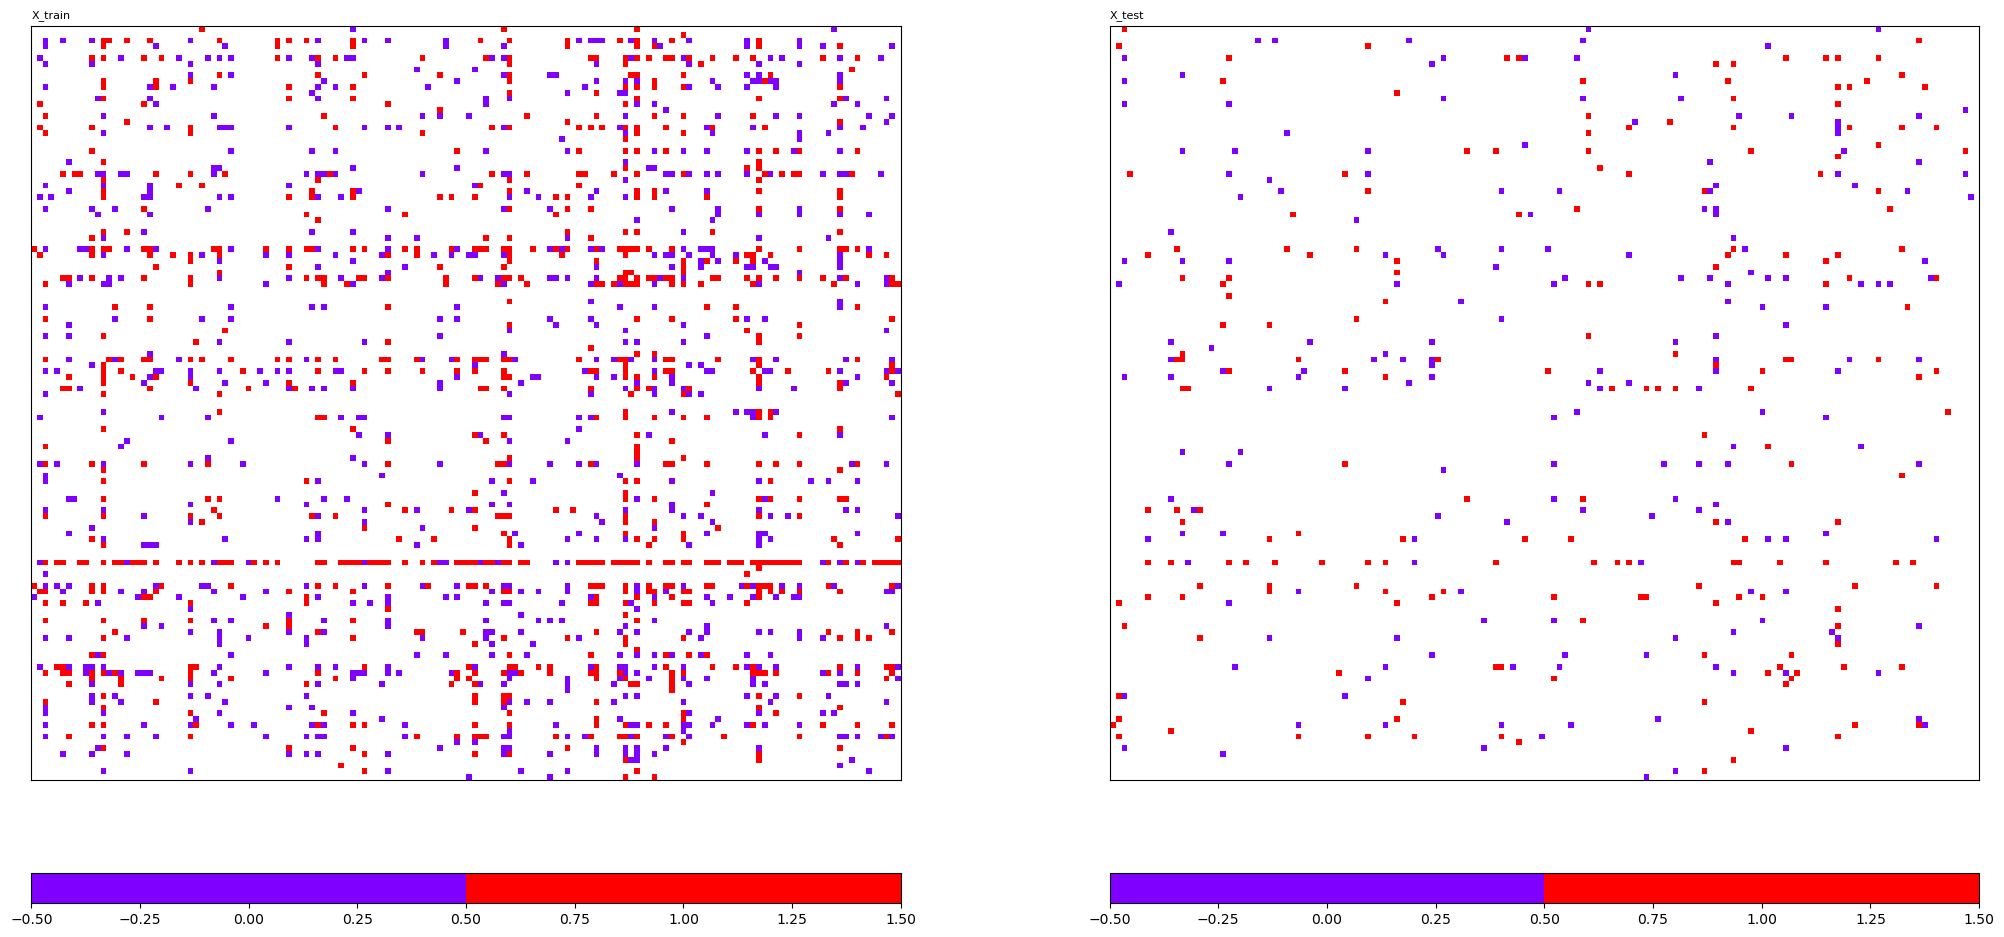

<Figure size 640x480 with 0 Axes>

In [44]:
s = [(X_train, [0, 0], 'X_train'), (X_test, [0, 1], 'X_test')]
show_matrix(settings=s, colorbar=True, cmap='rainbow', discrete=True, center=True, keep_nan=True)

# cmf-1, means

In [45]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter)
model.fit(X_train)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_
display(miu)

0.5

In [46]:
def show_results(means=True):
    P = A @ B.T
    if means is True:
        for r in range(P.shape[0]):
            P[r, :] += a[r]
        for c in range(P.shape[1]):
            P[:, c] += b[c]
        P += miu

    rows, cols = X_train.tocoo().row, X_train.tocoo().col
    X_recover = np.empty(shape=X_train.shape)
    X_recover.fill(np.nan)
    for i in range(len(rows)):
        X_recover[rows[i], cols[i]] = P[rows[i], cols[i]]
    X_recover = csr_matrix(X_recover)

    rows, cols = X_test.tocoo().row, X_test.tocoo().col
    X_predict = np.empty(shape=X_test.shape)
    X_predict.fill(np.nan)
    for i in range(len(rows)):
        X_predict[rows[i], cols[i]] = P[rows[i], cols[i]]
    X_predict = csr_matrix(X_predict)

    rng = [200, 200]
    settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
                (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
                (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
                (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
                (P[:rng[0], :rng[1]], [0, 2], 'all predict')]
    show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

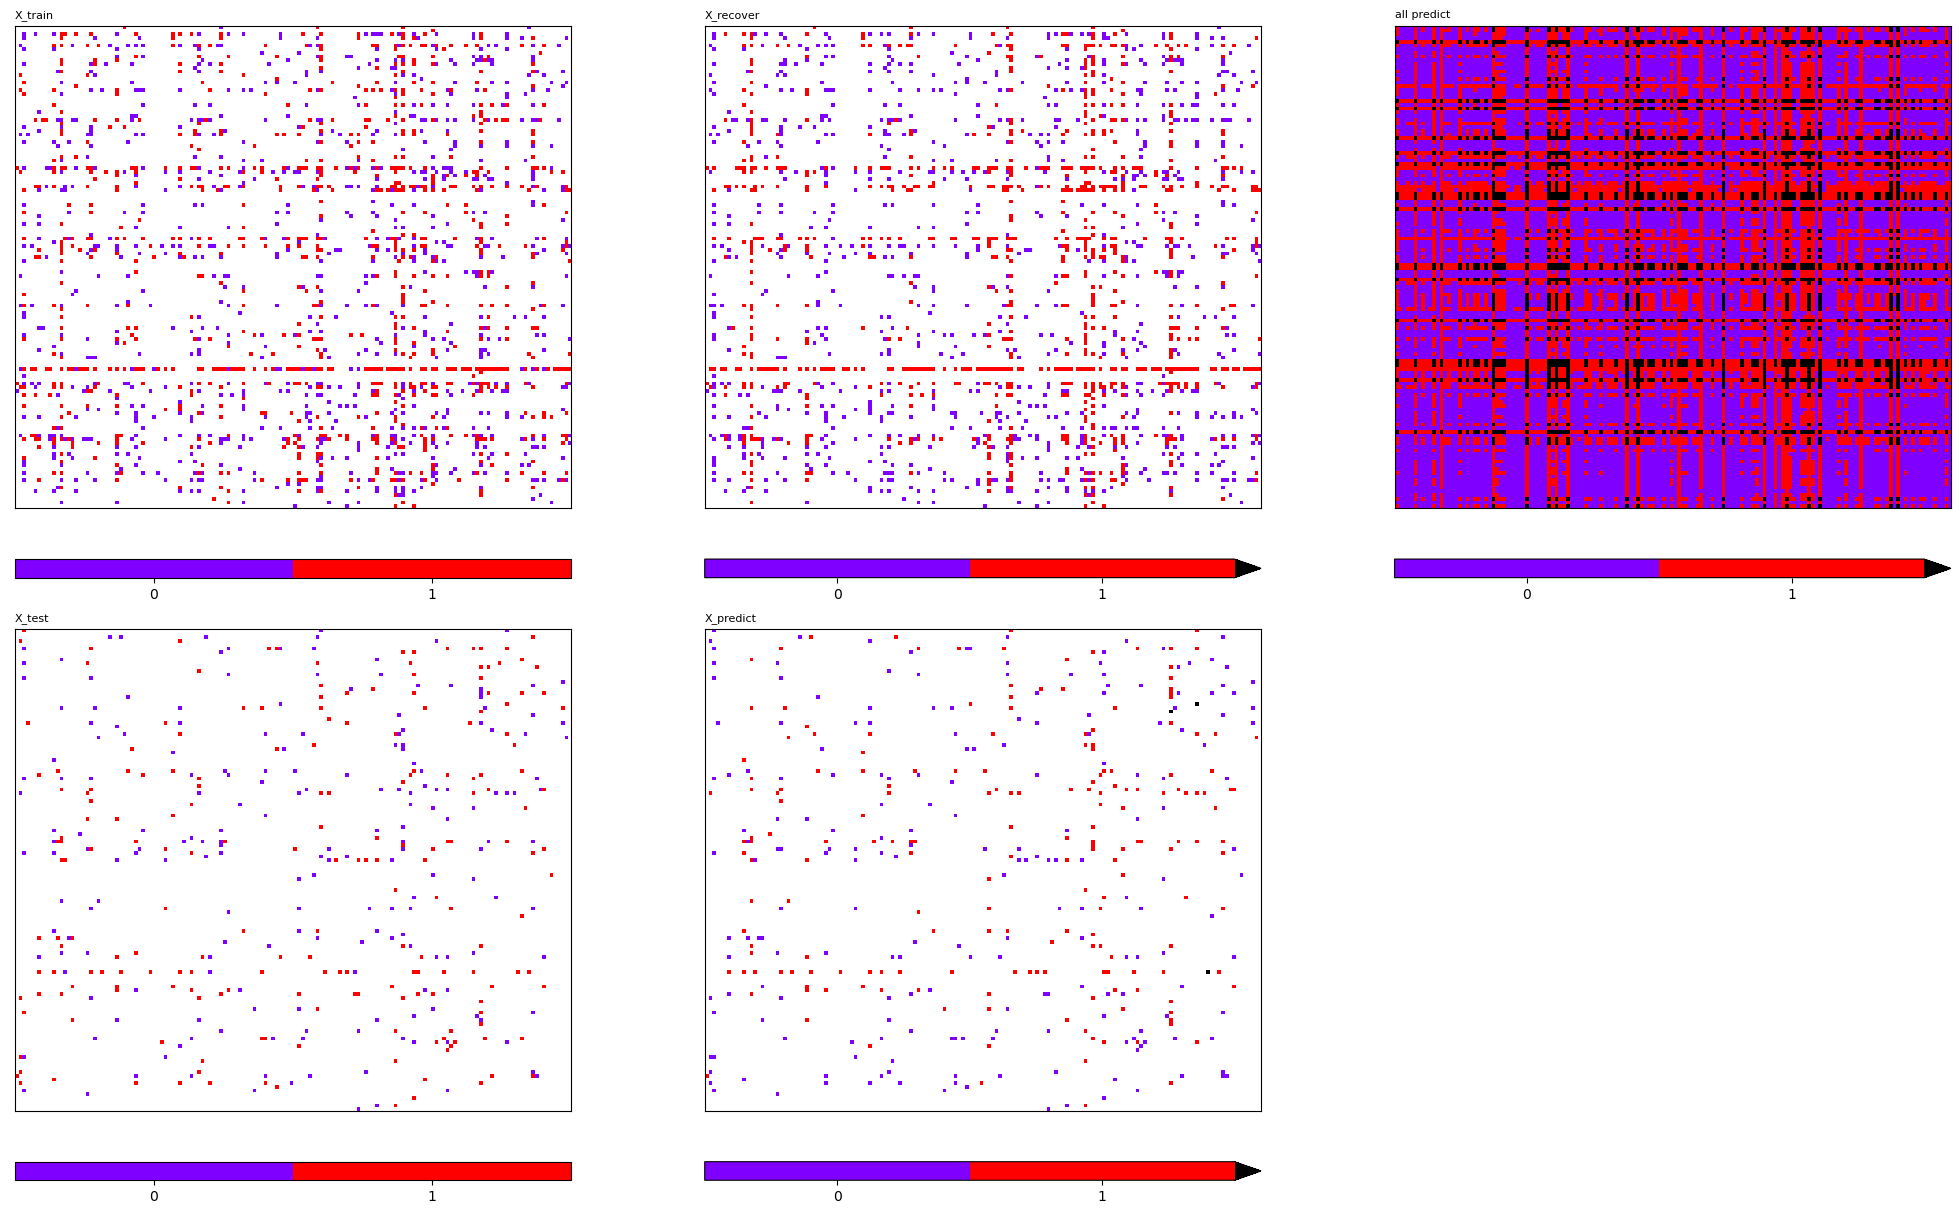

<Figure size 640x480 with 0 Axes>

In [47]:
show_results(means=True)

# cmf-1

In [48]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False)
model.fit(X_train)

A, B = model.A_, model.B_
P = A @ B.T

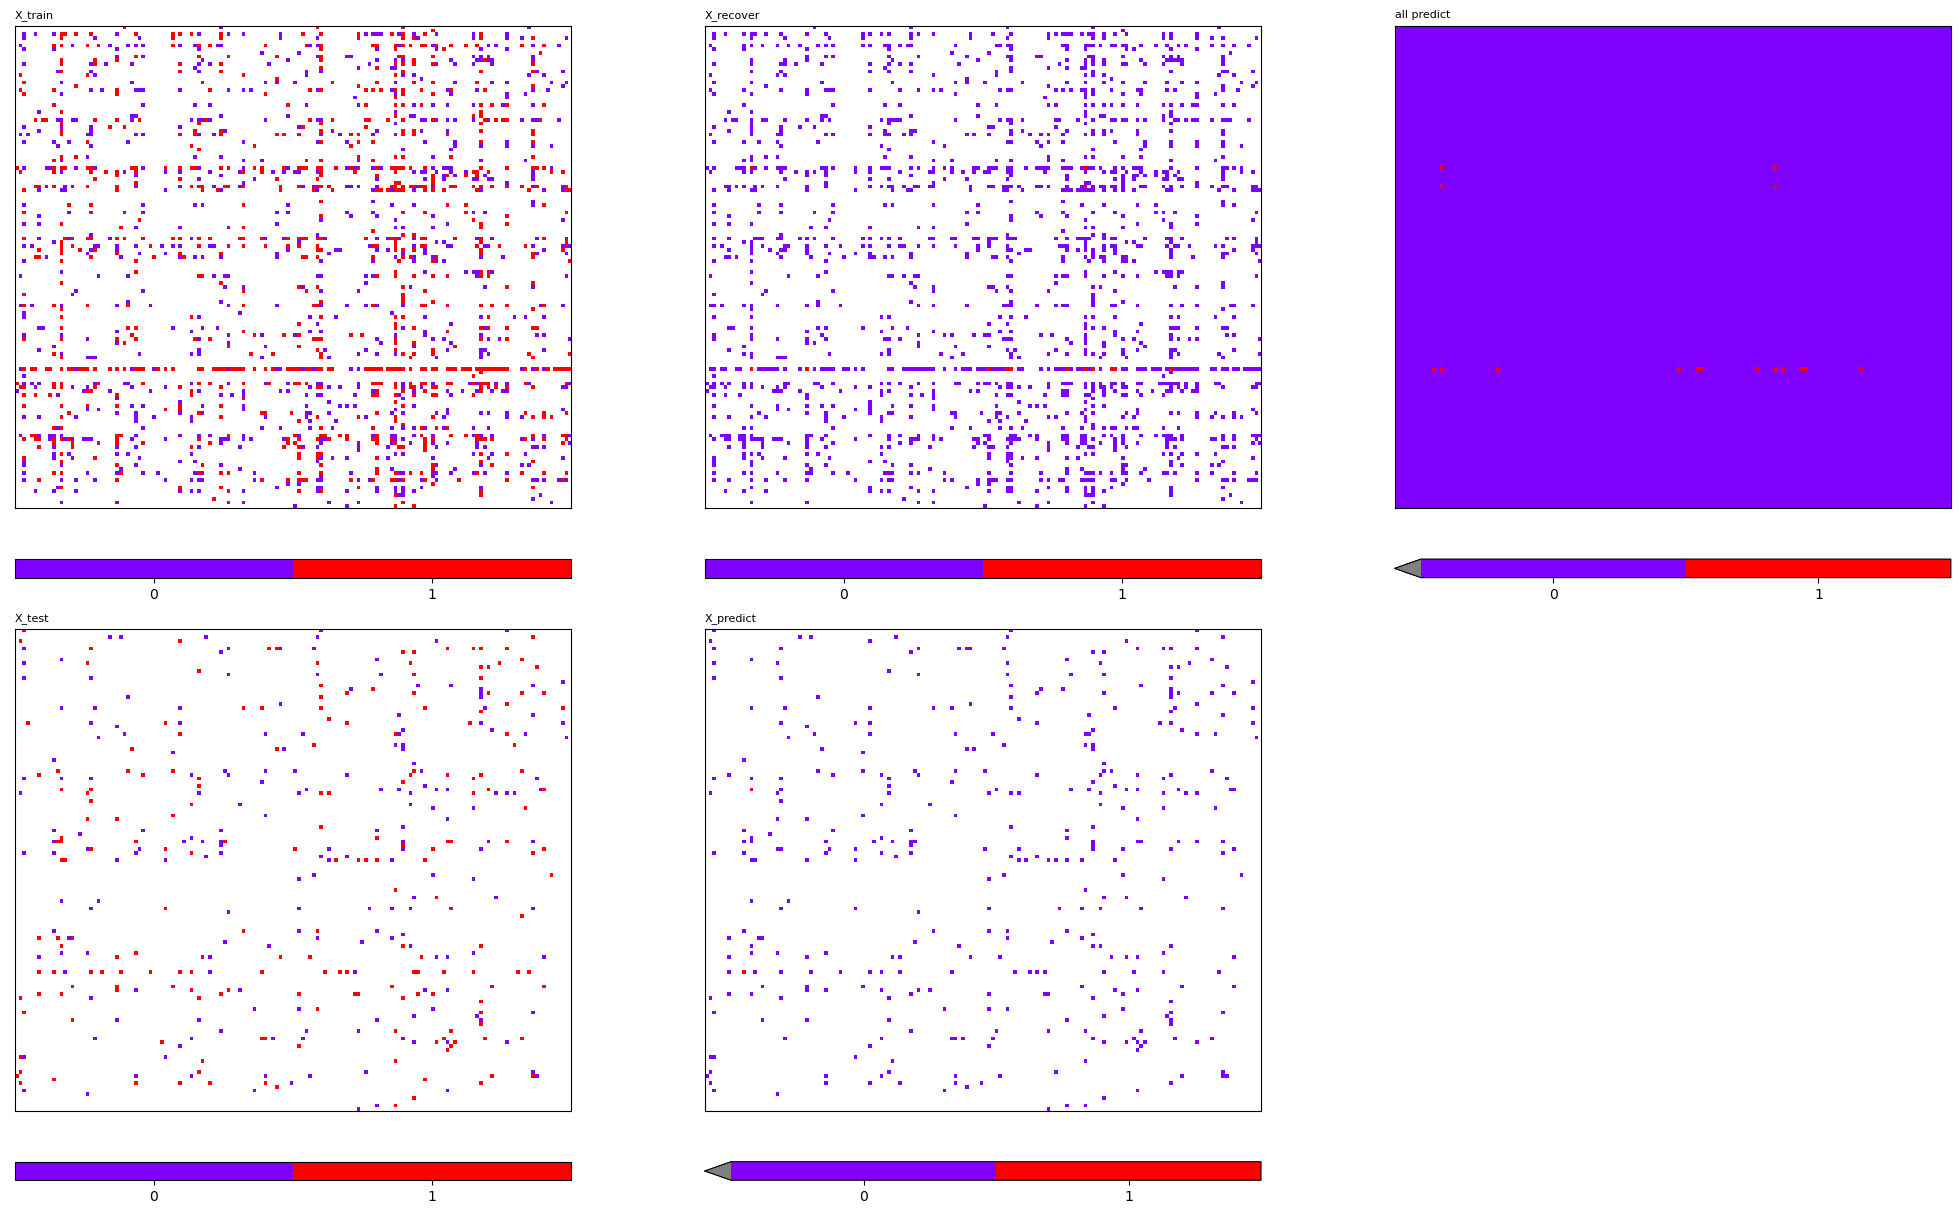

<Figure size 640x480 with 0 Axes>

In [49]:
show_results(means=False)

# cmf-1, lbfgs, means

In [50]:
model = CMF(method="lbfgs", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter)
model.fit(X_train)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_

P = A @ B.T
for r in range(P.shape[0]):
    P[r, :] += a[r]
for c in range(P.shape[1]):
    P[:, c] += b[c]
P += miu

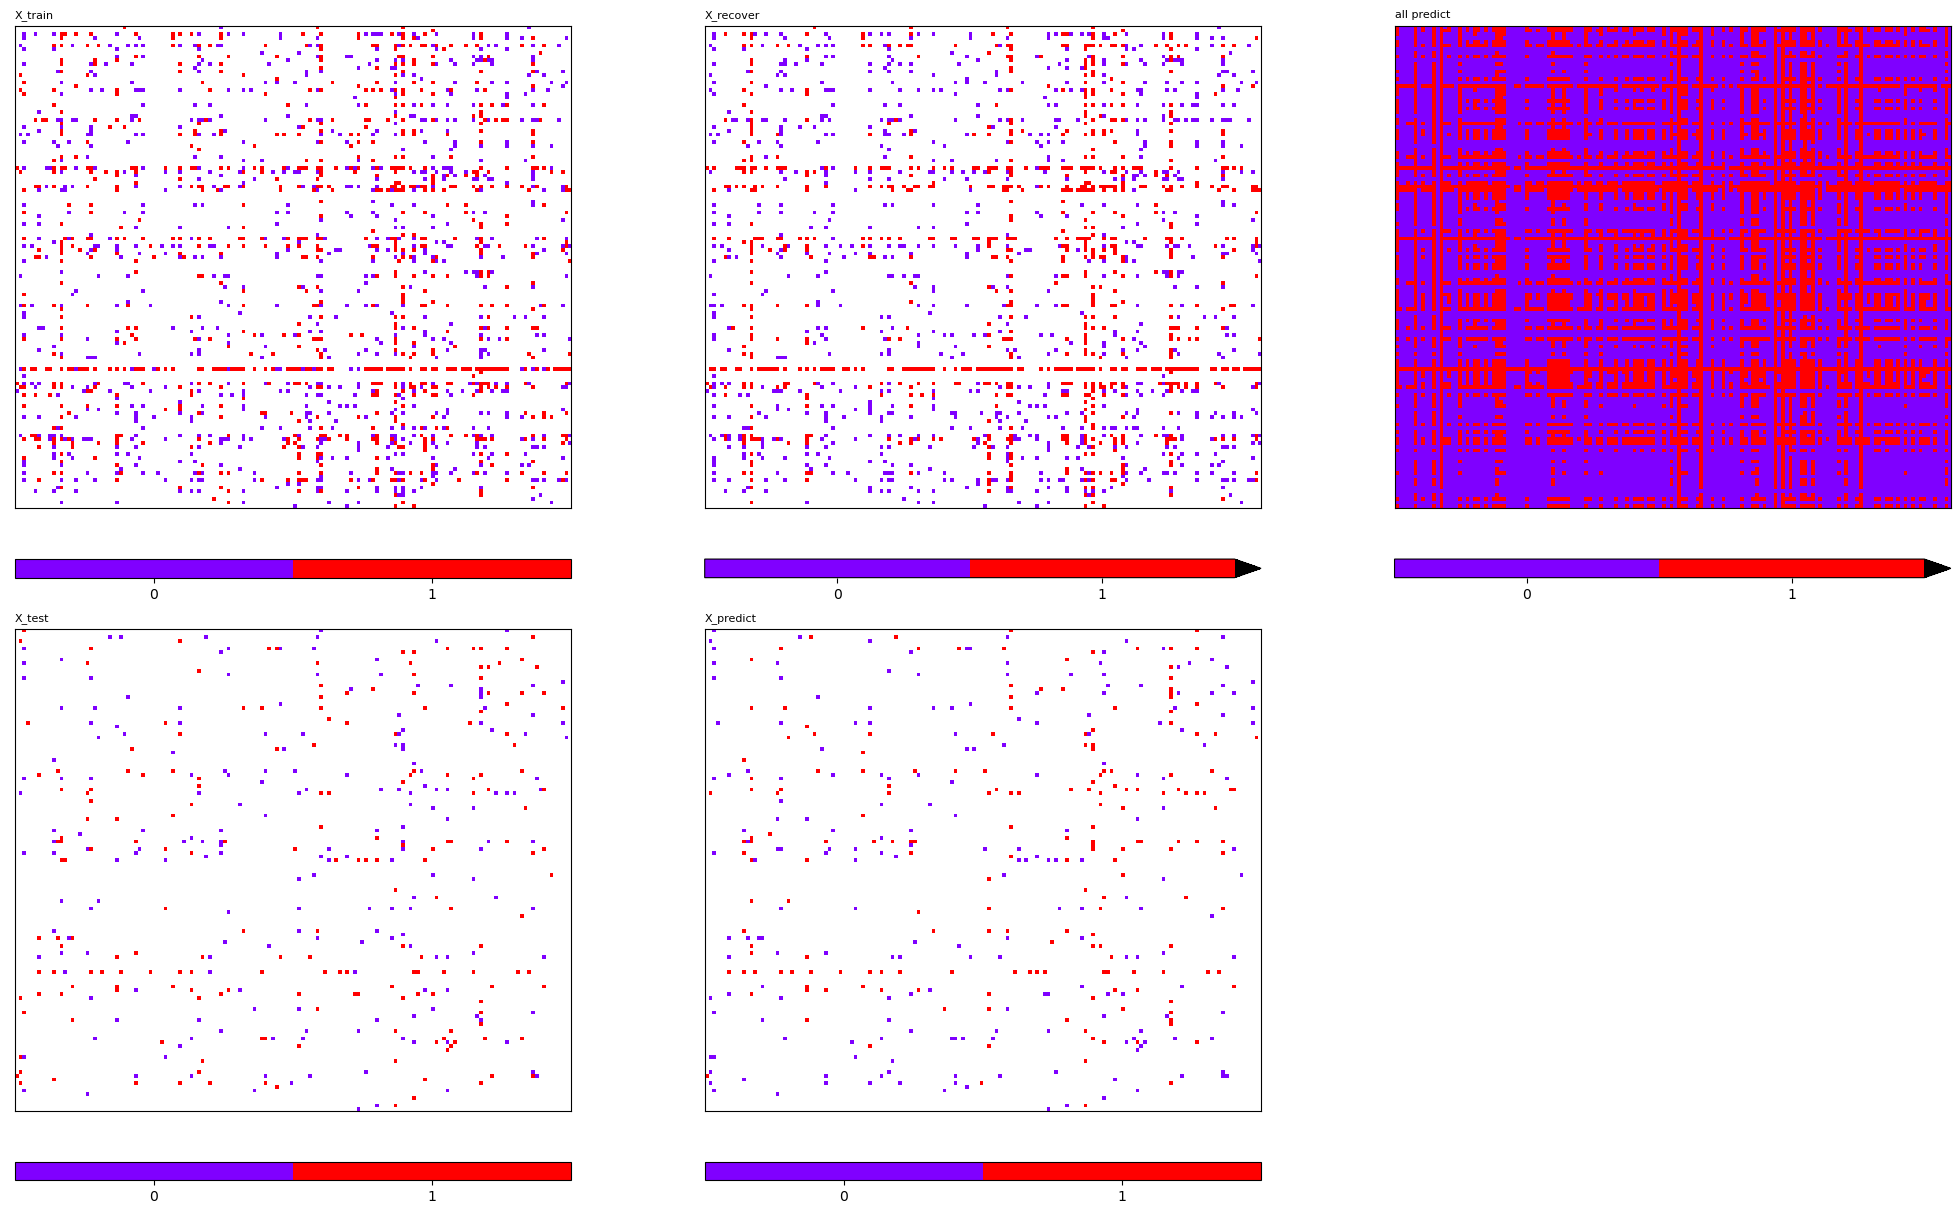

<Figure size 640x480 with 0 Axes>

In [51]:
show_results(means=True)

# cmf-1, lbfgs

In [52]:
model = CMF(method="lbfgs", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False)
model.fit(X_train)

A, B = model.A_, model.B_

P = A @ B.T

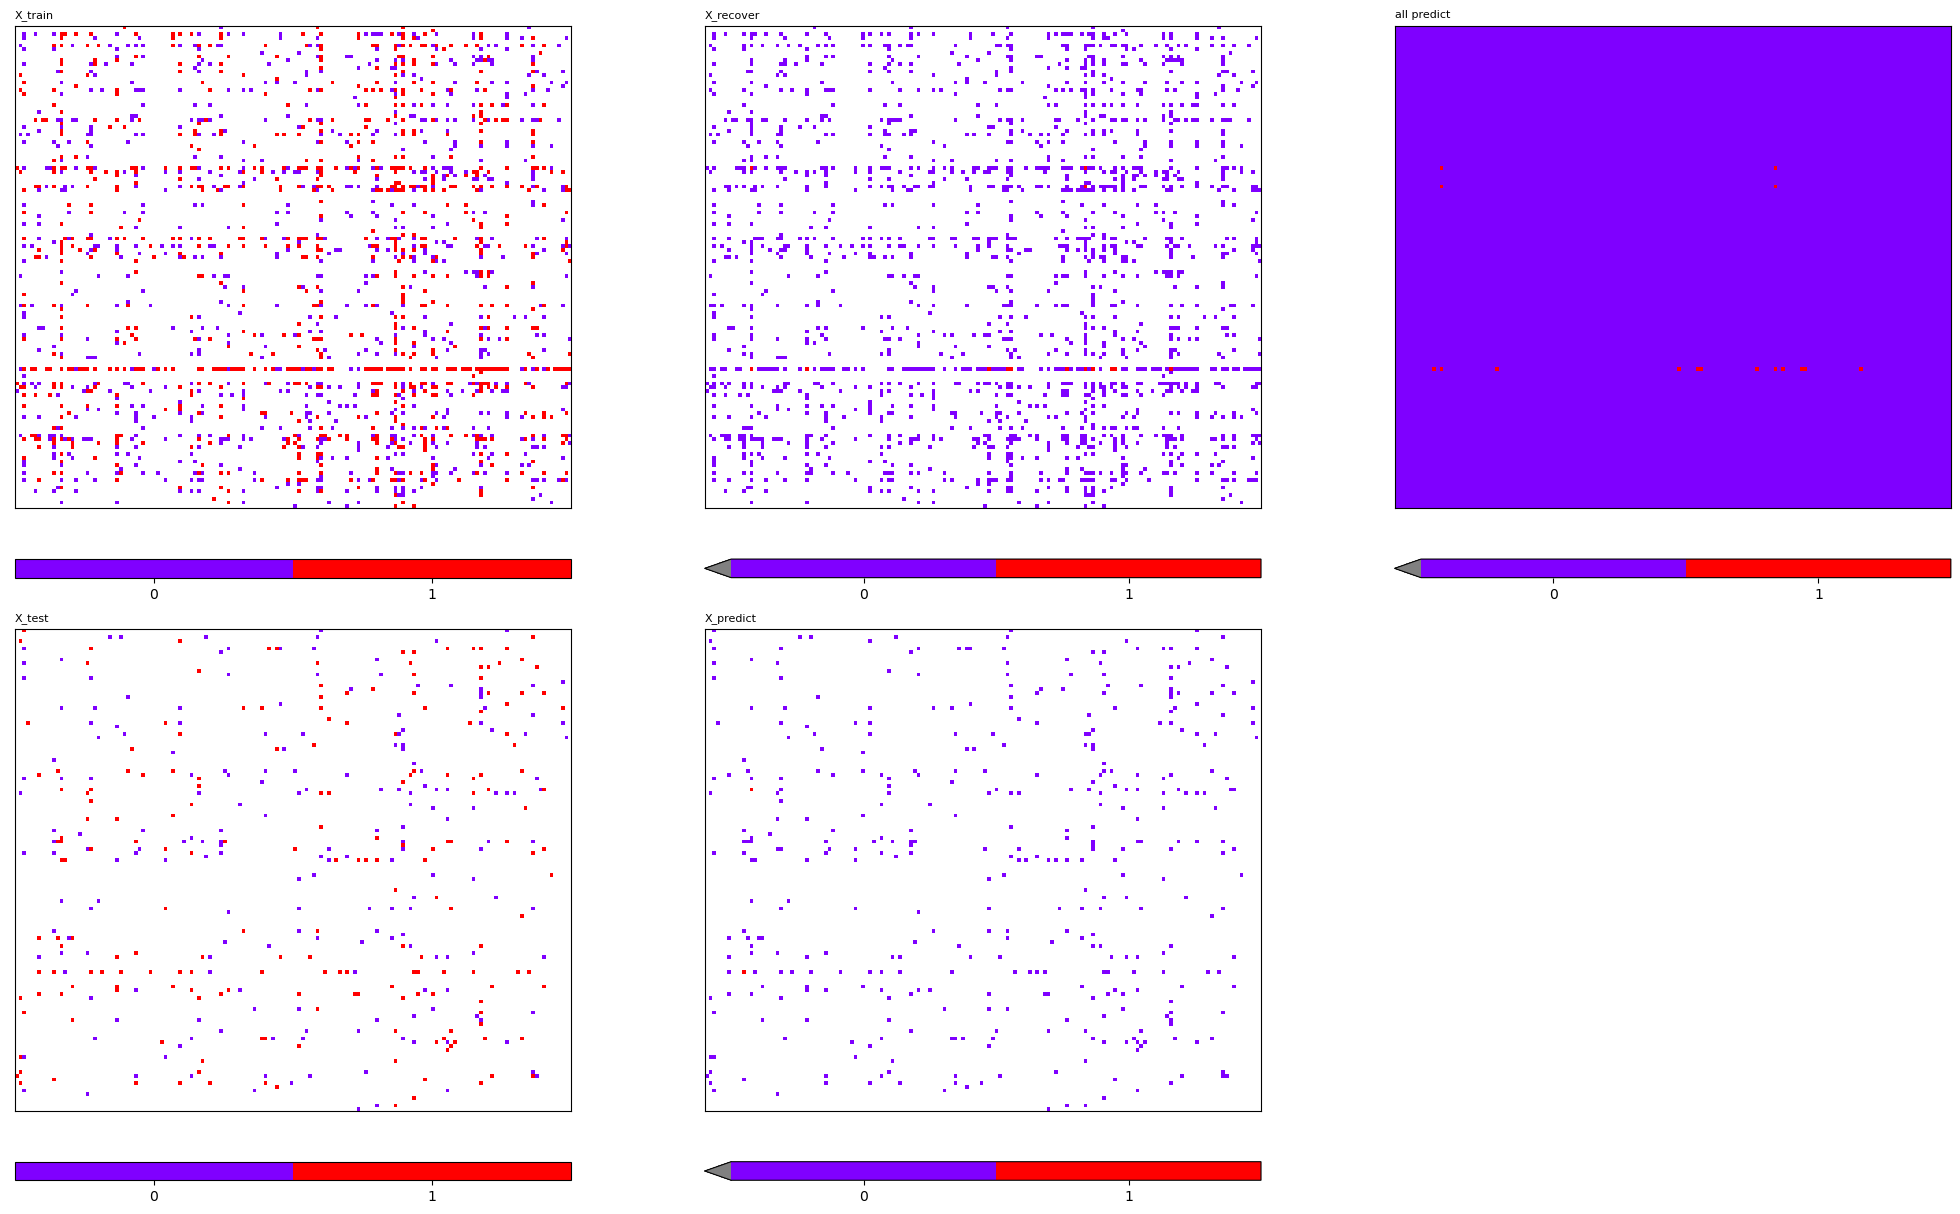

<Figure size 640x480 with 0 Axes>

In [53]:
show_results(means=False)

# cmf-3, als, means

In [67]:
model = CMF(method="als", k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, verbose=False)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_

P = A @ B.T
for r in range(P.shape[0]):
    P[r, :] += a[r]
for c in range(P.shape[1]):
    P[:, c] += b[c]
P += miu

c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\cmfrec\__init__.py:186: UserWarning: Warning: will fit a model with centering and non-negativity constraints.
  warnings.warn("Warning: will fit a model with centering and non-negativity constraints.")
c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\cmfrec\__init__.py:188: UserWarning: Warning: will fit a model with centering in 'U' and non-negativity constraints in 'C'.
  warnings.warn("Warning: will fit a model with centering in 'U' and non-negativity constraints in 'C'.")
c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\cmfrec\__init__.py:190: UserWarning: Warning: will fit a model with centering in 'I' and non-negativity constraints in 'D'.
  warnings.warn("Warning: will fit a model with centering in 'I' and non-negativity constraints in 'D'.")


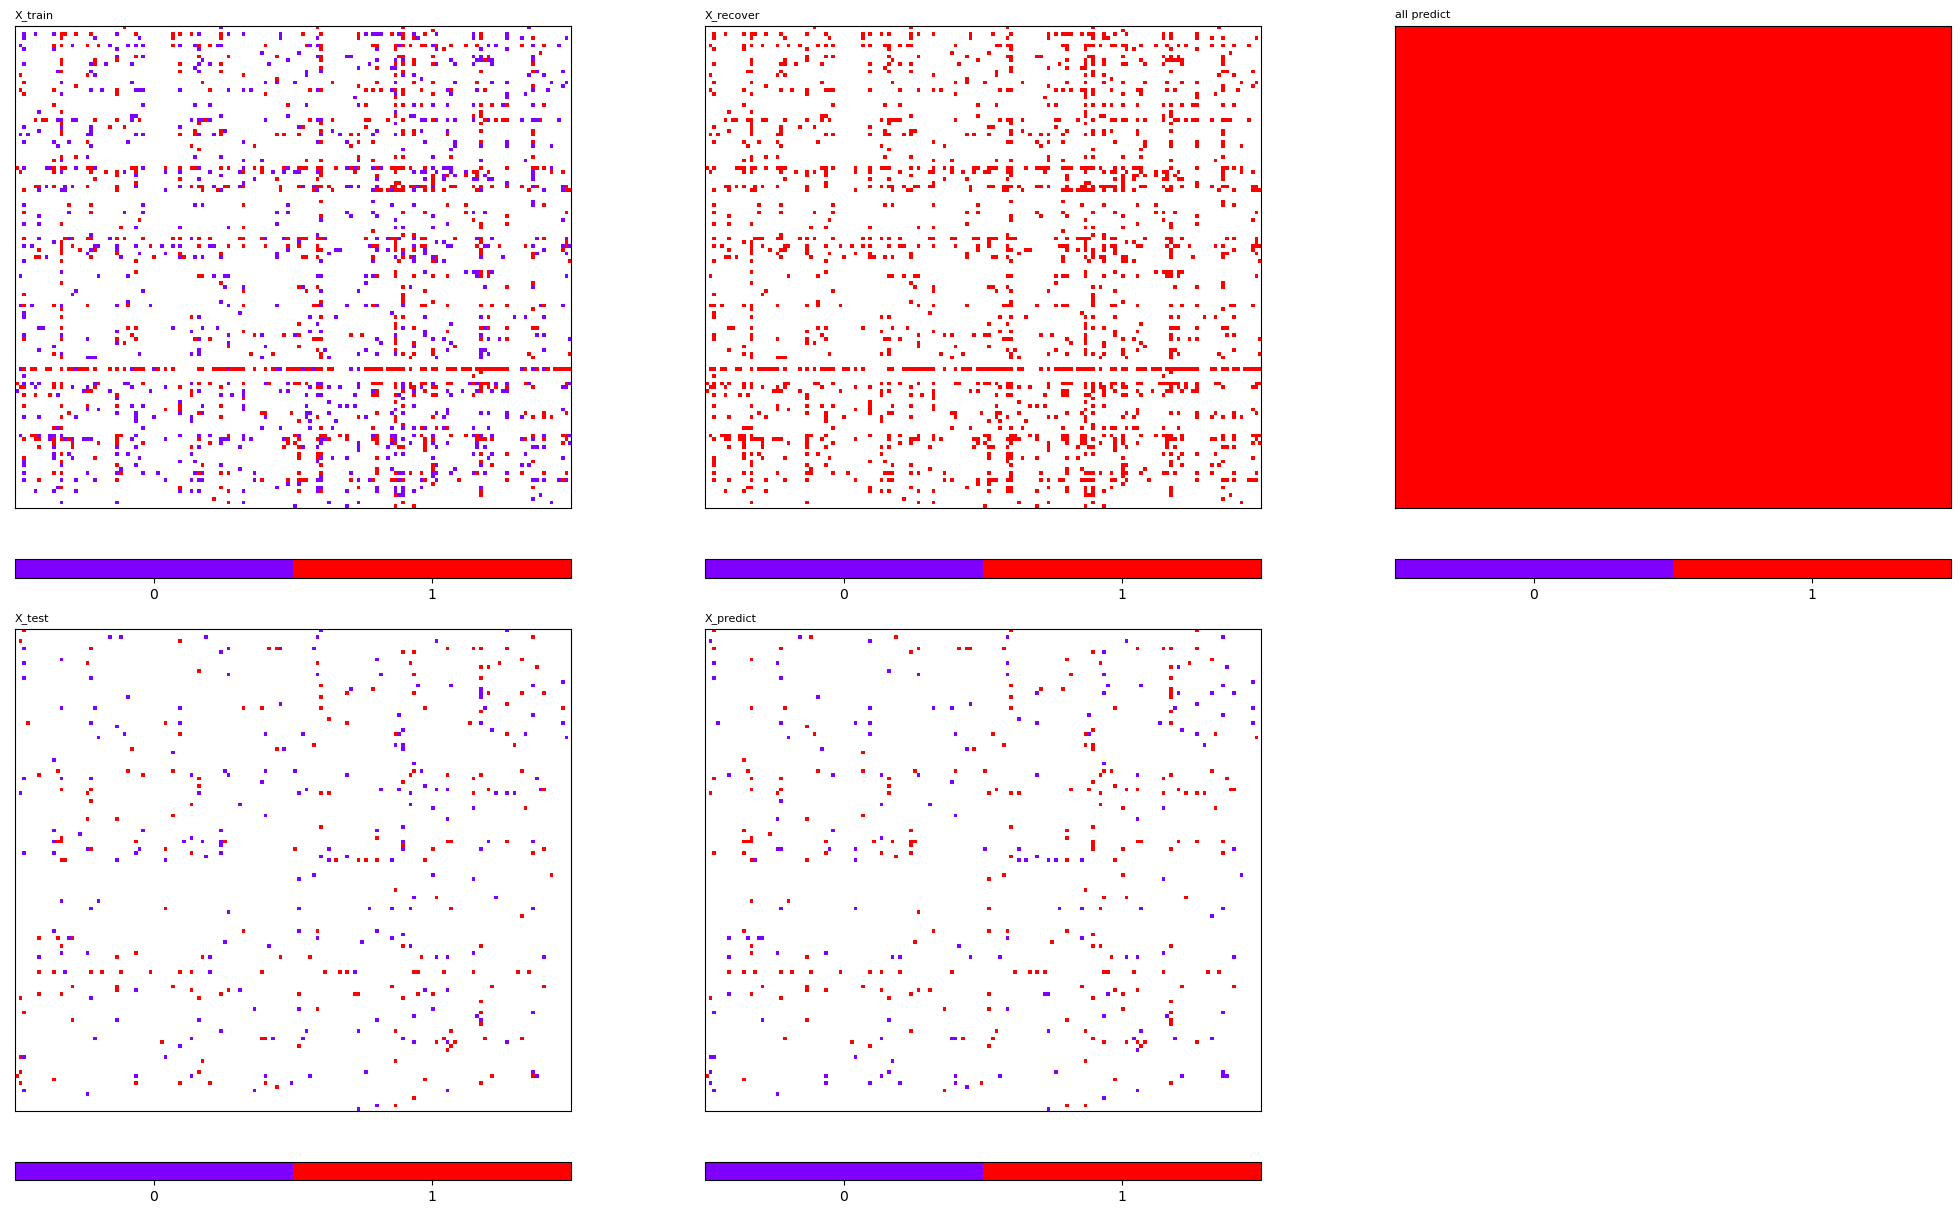

<Figure size 640x480 with 0 Axes>

In [68]:
show_results(means=True)

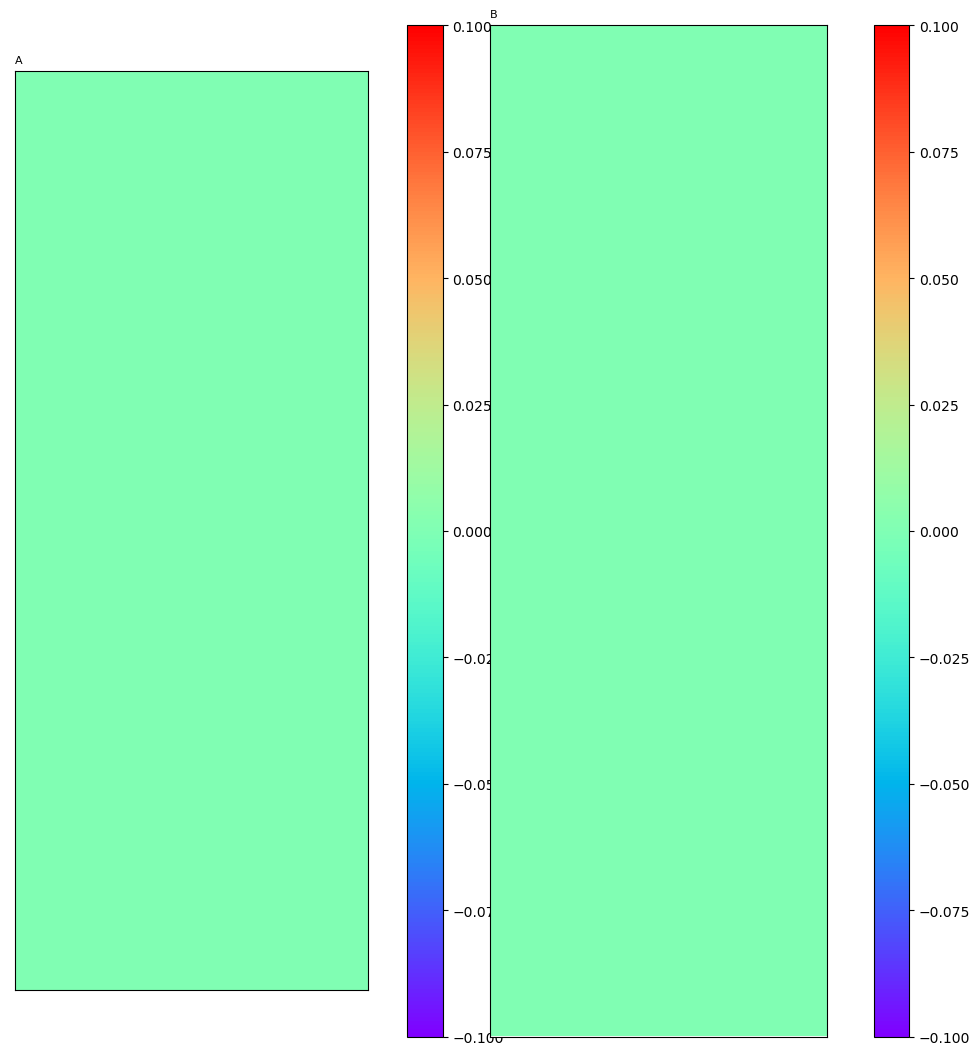

<Figure size 640x480 with 0 Axes>

In [69]:
# show factors

show_matrix(settings=[(A, [0, 0], 'A'), (B, [0, 1], 'B')], colorbar=True, cmap='rainbow', discrete=False, center=True, keep_nan=True)

# cmf-3, als

In [56]:
model = CMF(method="als", k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, verbose=False, user_bias=False, item_bias=False, center=False)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
P = A @ B.T

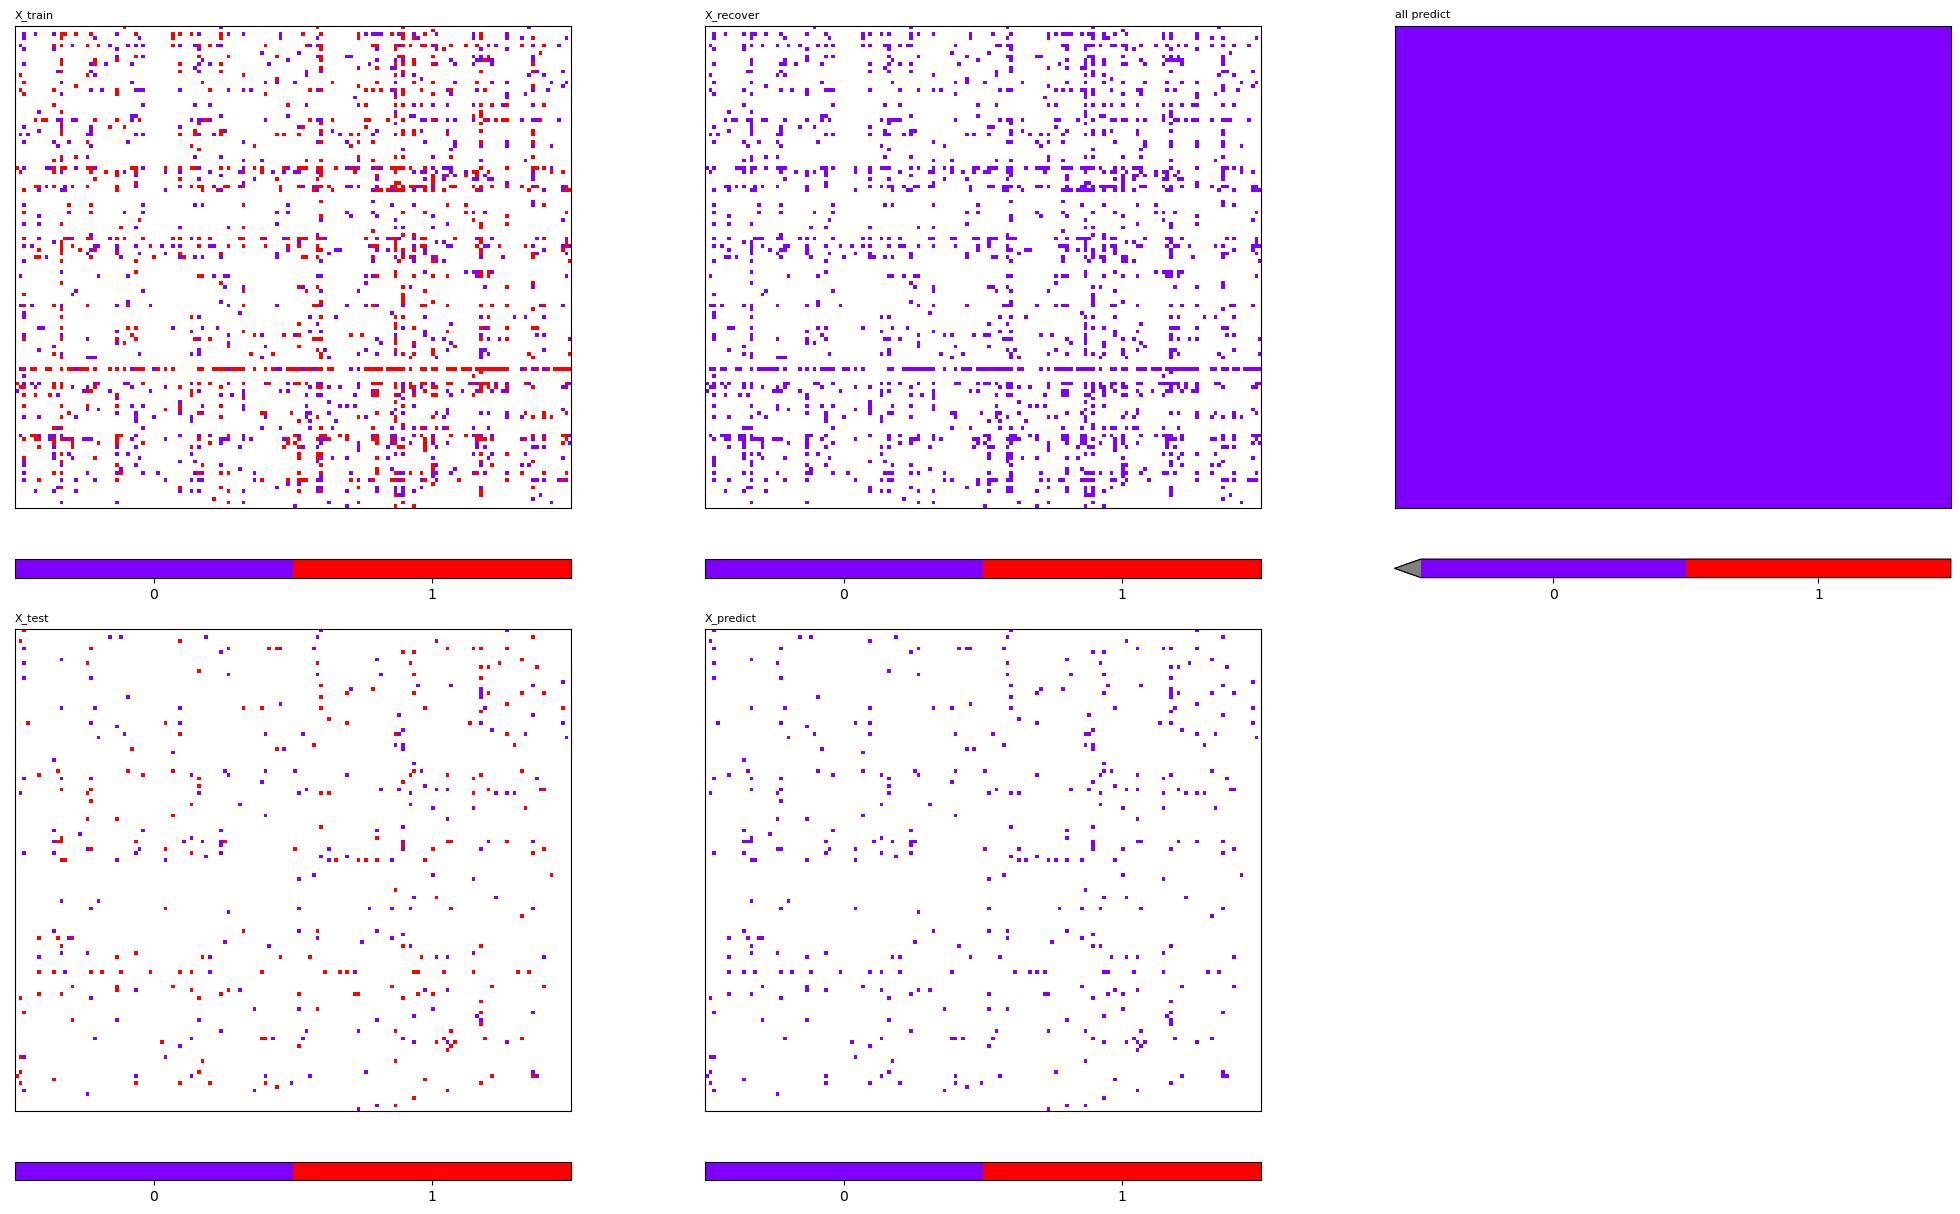

<Figure size 640x480 with 0 Axes>

In [57]:
show_results(means=False)

# cmf-3, lbfgs, mean

In [58]:
# for the sigmoid transformations:
model = CMF(method="lbfgs", maxiter=maxiter, k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
a, b, miu = model.user_bias_, model.item_bias_, model.glob_mean_

P = A @ B.T
for r in range(P.shape[0]):
    P[r, :] += a[r]
for c in range(P.shape[1]):
    P[:, c] += b[c]
P += miu

Iteration 10   - f(x)= 101      - ||g(x)||= 0.00727  - ls= 1


Optimization terminated
	A rounding error occurred; alternatively, no line-search step satisfies the sufficient decrease and curvature conditions.
	niter: 10, nfev: 28


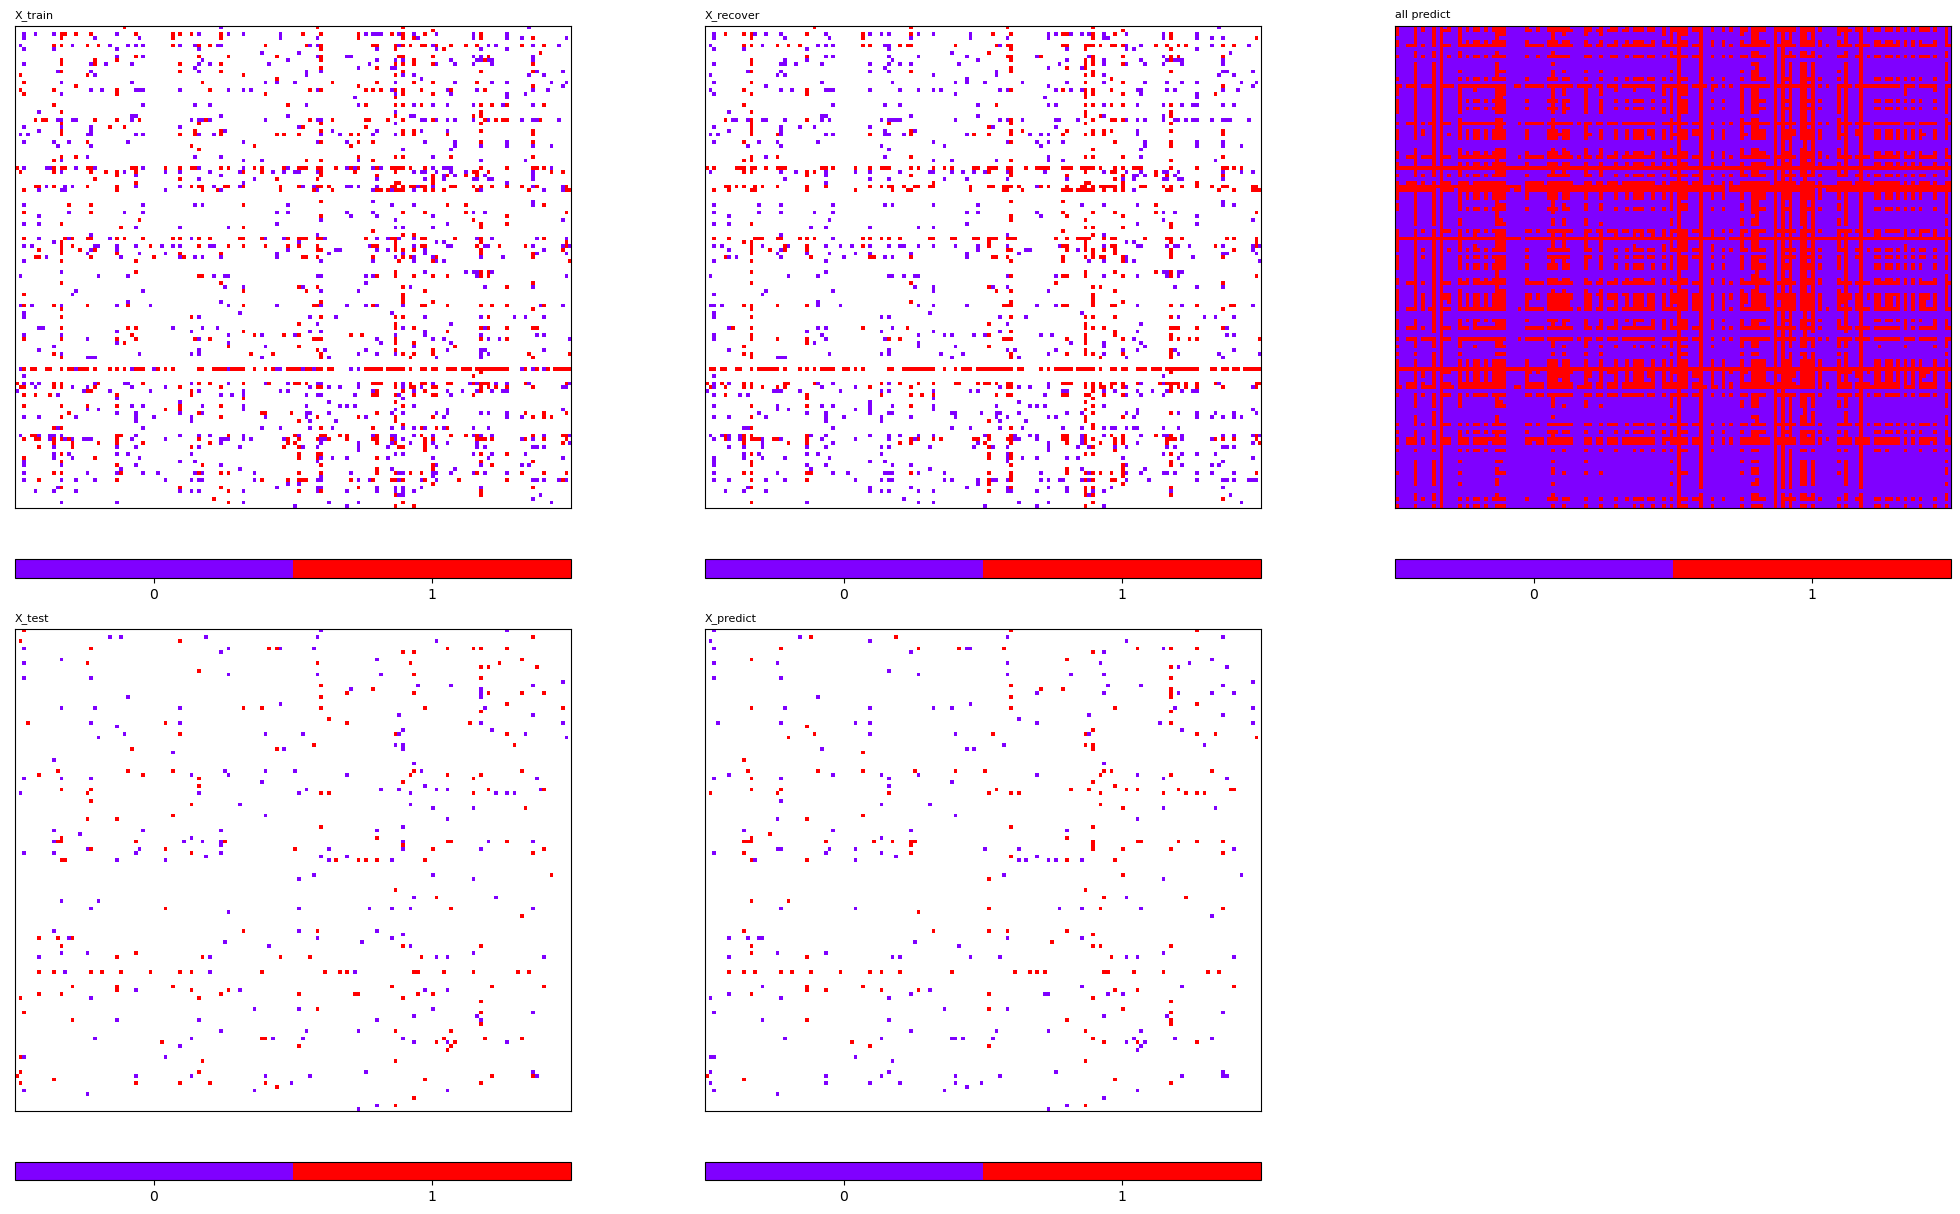

<Figure size 640x480 with 0 Axes>

In [59]:
show_results(means=True)

# cmf-3, lbfgs

In [71]:
# for the sigmoid transformations:
model = CMF(method="lbfgs", maxiter=maxiter, k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, user_bias=False, item_bias=False, center=False)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
P = A @ B.T

Iteration 10   - f(x)= 218      - ||g(x)||= 0.00018  - ls= 1


Optimization terminated
	Success: reached convergence (gtol).
	niter: 13, nfev: 15


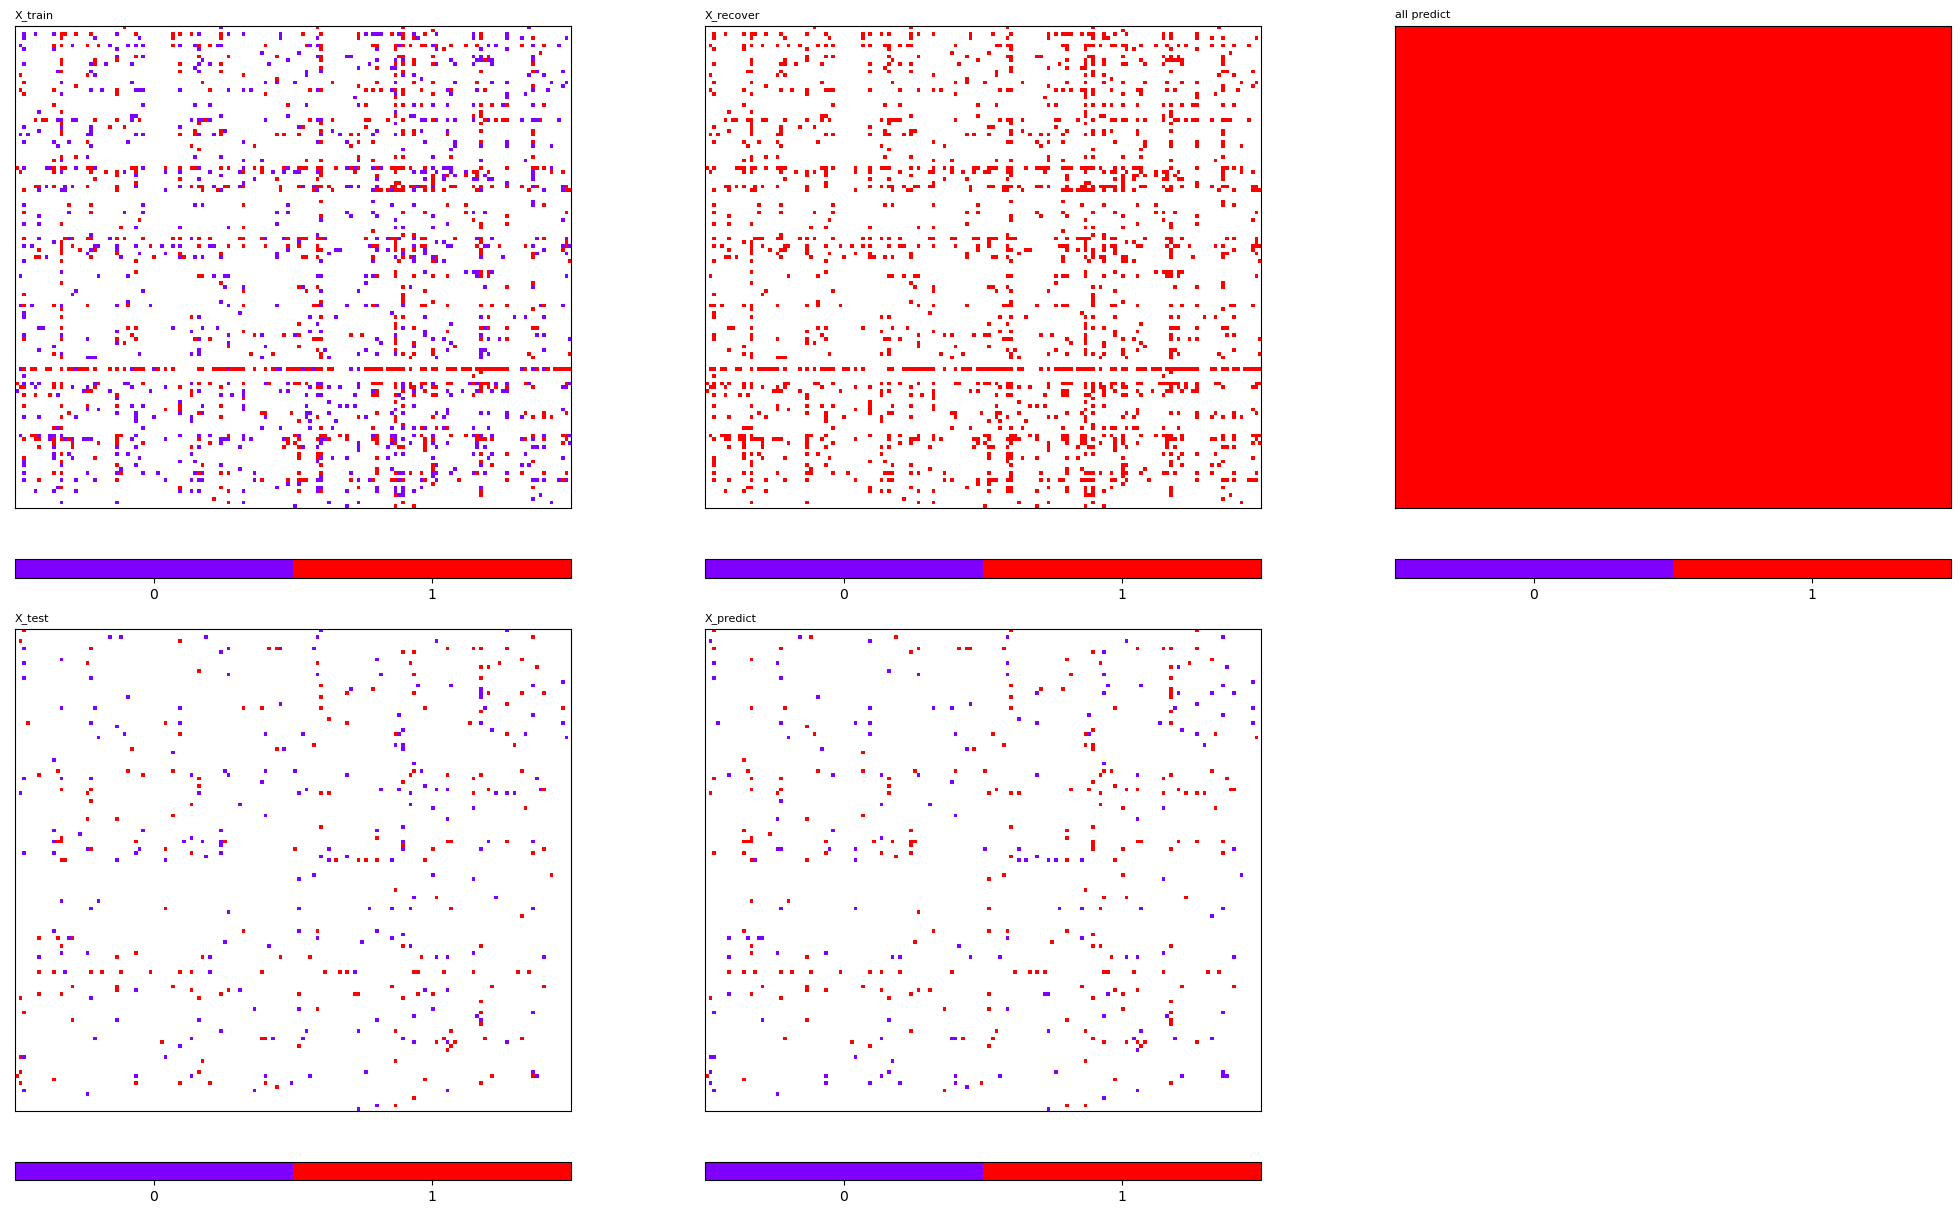

<Figure size 640x480 with 0 Axes>

In [72]:
show_results(means=True)

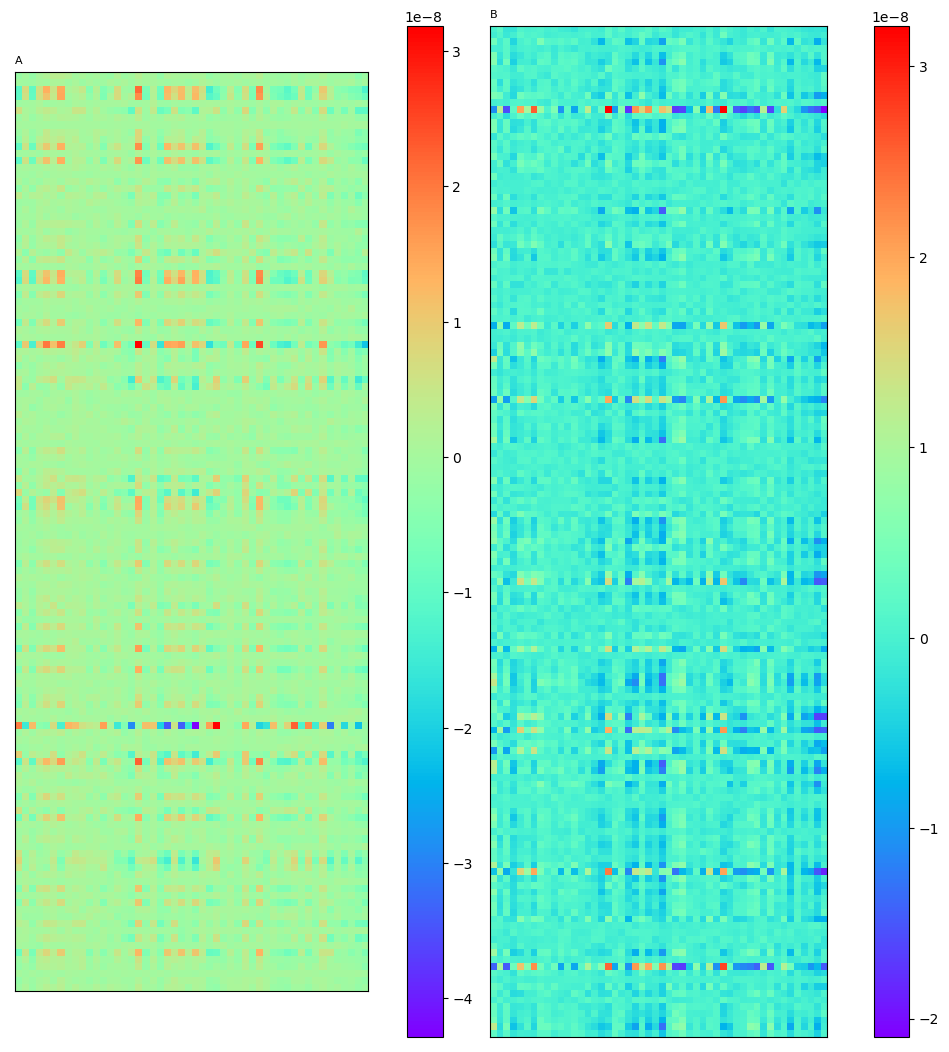

<Figure size 640x480 with 0 Axes>

In [73]:
# show factors

show_matrix(settings=[(A, [0, 0], 'A'), (B, [0, 1], 'B')], colorbar=True, cmap='rainbow', discrete=False, center=True, keep_nan=True)